Buyer Before Operation:
    sl no.  v1  v2  v3  Score
17      18  14  25  24   23.3
4        5  22  24  21   22.0
1        2  23  21  21   21.2
10      11  22  23  20   21.1
11      12  17  23  20   20.6
16      17  23  11  25   20.6
18      19  20  25  18   20.3
15      16  24  17  21   20.1
5        6  13  23  18   19.0
13      14  20  10  21   17.6
8        9  25  25  12   17.2
0        1  17  13  19   17.0
7        8  20  24  12   16.4
14      15  20  23  12   16.1
3        4  12  16  16   15.6
2        3  18  10  18   15.6
12      13  10  22  11   14.2
9       10  22  10  15   14.2
19      20  10  10  15   13.0
6        7  11  15  10   11.6

Seller Before Operation:
    sl no.  v4  v5  v6  Score
3        4  25  21  24  24.15
11      12  24  13  21  21.60
0        1  24  14  20  21.50
9       10  22  19  17  20.30
10      11  22  23  14  20.15
6        7  24  16  13  20.05
17      18  18  21  20  18.95
8        9  21  14  16  18.70
13      14  16  18  24  18.30
2        3  20  24  

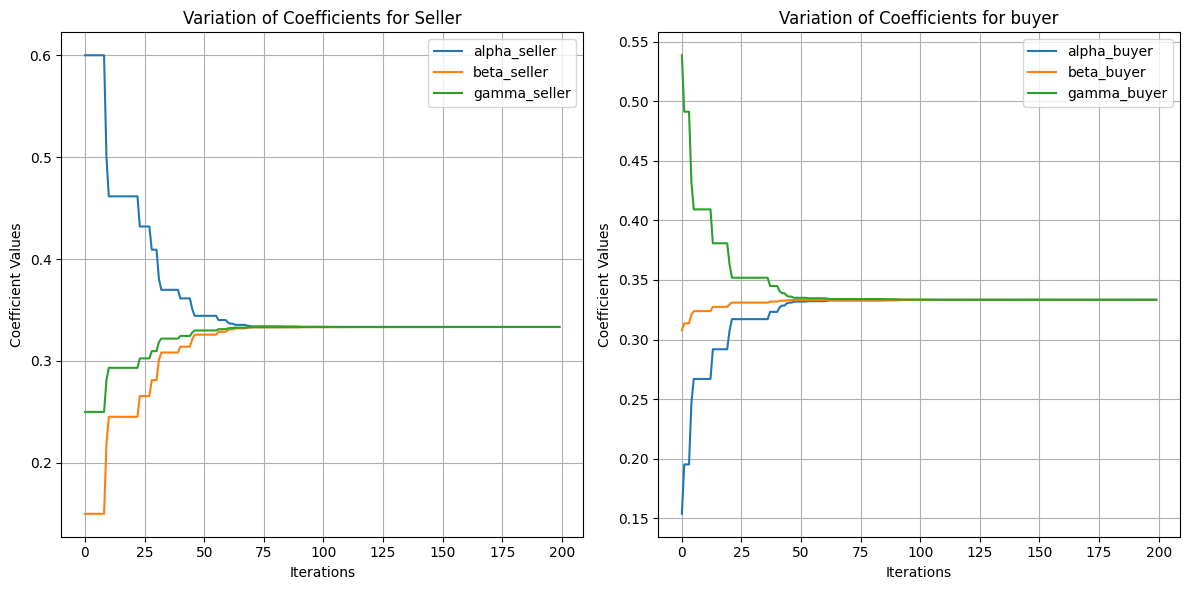

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

alpha_seller_history = []
beta_seller_history = []
gamma_seller_history = []
alpha_buyer_history = []
beta_buyer_history = []
gamma_buyer_history = []
# Function to generate random values between 10 and 25 for v1, v2, ..., v6
def generate_random_values(num_values=20):
    return np.random.randint(10, 26, size=num_values)

# Function to calculate the SUM of v5 column
def calculate_v5_sum(df_seller_sorted):
    return df_seller_sorted["v5"].sum()

# Function to update Q-values using Q-learning
def update_q_value(q_table, state, action, reward, next_state, learning_rate, discount_factor):
    current_q = q_table[state][action]
    next_max_q = np.max(q_table[next_state])
    updated_q = current_q + learning_rate * (reward + discount_factor * next_max_q - current_q)
    q_table[state][action] = updated_q

# Function to select an action based on epsilon-greedy policy
def select_action(q_table, state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice(q_table.shape[1])
    else:
        return np.argmax(q_table[state])

# Function to convert coefficients to state index
def get_state_index(alpha_buyer, beta_buyer, gamma_buyer):
    num_intervals = 10
    return int(alpha_buyer * num_intervals) * (num_intervals + 1) ** 2 + int(beta_buyer * num_intervals) * (num_intervals + 1) + int(gamma_buyer * num_intervals)

# Function to optimize coefficients using reward-based RL
def optimize_coefficients(df_buyer_sorted, df_seller_sorted, alpha_buyer, beta_buyer, gamma_buyer, alpha_seller, beta_seller, gamma_seller):
    # Hyperparameters
    learning_rate = 0.1
    discount_factor = 0.9
    epsilon = 0.2
    max_iterations = 1000

    # Initialize Q-table with zeros
    num_intervals = 10
    num_states = (num_intervals + 1) ** 3
    q_table_buyer = np.zeros((num_states, 3))
    q_table_seller = np.zeros((num_states, 3))

    for iteration in range(max_iterations):
        # Get the current state (coefficients) index for Q-table indexing
        state_buyer = get_state_index(alpha_buyer, beta_buyer, gamma_buyer)
        state_seller = get_state_index(alpha_seller, beta_seller, gamma_seller)

        # Select an action (coefficient adjustment) using epsilon-greedy policy for the buyer
        action_buyer = select_action(q_table_buyer, state_buyer, epsilon)

        # Apply the action (adjust the buyer's coefficients)
        coeff_adjustment = action_buyer * 0.1
        alpha_buyer_temp = np.clip(alpha_buyer + coeff_adjustment, 0.0, 1.0)
        beta_buyer_temp = np.clip(beta_buyer + coeff_adjustment, 0.0, 1.0)
        gamma_buyer_temp = np.clip(gamma_buyer + coeff_adjustment, 0.0, 1.0)

                # Ensure the sum of buyer's coefficients is 1
        sum_coeffs_buyer = alpha_buyer_temp + beta_buyer_temp + gamma_buyer_temp
        alpha_buyer_temp /= sum_coeffs_buyer
        beta_buyer_temp /= sum_coeffs_buyer
        gamma_buyer_temp /= sum_coeffs_buyer


        # Calculate the new SUM of v5 column with the updated buyer's coefficients
        v5_sum_new = calculate_v5_sum(df_seller_sorted)

        # Calculate the reward for the buyer as the reduction in the SUM of v5 column
        reward_buyer = calculate_v5_sum(df_seller_sorted) - v5_sum_new

        # Get the next state after applying the action for the buyer
        next_state_buyer = get_state_index(alpha_buyer_temp, beta_buyer_temp, gamma_buyer_temp)

        # Update buyer's Q-value using Q-learning
        update_q_value(q_table_buyer, state_buyer, action_buyer, reward_buyer, next_state_buyer, learning_rate, discount_factor)

        # Select an action (coefficient adjustment) using epsilon-greedy policy for the seller
        action_seller = select_action(q_table_seller, state_seller, epsilon)

        # Apply the action (adjust the seller's coefficients)
        coeff_adjustment = action_seller * 0.1
        alpha_seller_temp = np.clip(alpha_seller + coeff_adjustment, 0.0, 1.0)
        beta_seller_temp = np.clip(beta_seller + coeff_adjustment, 0.0, 1.0)
        gamma_seller_temp = np.clip(gamma_seller + coeff_adjustment, 0.0, 1.0)

        # Ensure the sum of seller's coefficients is 1
        sum_coeffs_seller = alpha_seller_temp + beta_seller_temp + gamma_seller_temp
        alpha_seller_temp /= sum_coeffs_seller
        beta_seller_temp /= sum_coeffs_seller
        gamma_seller_temp /= sum_coeffs_seller


        # Calculate the new SUM of v5 column with the updated seller's coefficients
        v5_sum_new = calculate_v5_sum(df_seller_sorted)

        # Calculate the reward for the seller as the reduction in the SUM of v5 column
        reward_seller = calculate_v5_sum(df_seller_sorted) - v5_sum_new

        # Get the next state after applying the action for the seller
        next_state_seller = get_state_index(alpha_seller_temp, beta_seller_temp, gamma_seller_temp)

        # Update seller's Q-value using Q-learning
        update_q_value(q_table_seller, state_seller, action_seller, reward_seller, next_state_seller, learning_rate, discount_factor)

        # Update coefficients for the buyer and seller
        alpha_buyer = alpha_buyer_temp
        beta_buyer = beta_buyer_temp
        gamma_buyer = gamma_buyer_temp
        alpha_seller = alpha_seller_temp
        beta_seller = beta_seller_temp
        gamma_seller = gamma_seller_temp

        # Append the updated values to the history lists
        alpha_buyer_history.append(alpha_buyer)
        beta_buyer_history.append(beta_buyer)
        gamma_buyer_history.append(gamma_buyer)
        alpha_seller_history.append(alpha_seller)
        beta_seller_history.append(beta_seller)
        gamma_seller_history.append(gamma_seller)

    return alpha_buyer, beta_buyer, gamma_buyer

data_buyer = {
    "sl no.": list(range(1, 21)),  # Generating sl no. from 1 to 20
    "v1": generate_random_values(),
    "v2": generate_random_values(),
    "v3": generate_random_values()
}

# Create DataFrame for Buyer (Table 1)
df_buyer = pd.DataFrame(data_buyer)

# Coefficients for Buyer (Table 1) (initially set to 0.5)
alpha_buyer = 0.1
beta_buyer = 0.3
gamma_buyer = 0.6

# Calculate the score for each row in Buyer (Table 1)
df_buyer["Score"] = alpha_buyer * df_buyer["v1"] + beta_buyer * df_buyer["v2"] + gamma_buyer * df_buyer["v3"]

# Sort Buyer (Table 1) based on the Score column in descending order
df_buyer_sorted = df_buyer.sort_values(by="Score", ascending=False)

# Print the "Buyer" table before the operation
print("Buyer Before Operation:")
print(df_buyer_sorted)

# Example data for Seller (Table 2)
data_seller = {
    "sl no.": list(range(1, 21)),  # Generating sl no. from 1 to 20
    "v4": generate_random_values(),
    "v5": generate_random_values(),
    "v6": generate_random_values()
}

# Create DataFrame for Seller (Table 2)
df_seller = pd.DataFrame(data_seller)

# Coefficients for Seller (Table 2) (initially set to 0.5)
alpha_seller = 0.6
beta_seller = 0.15
gamma_seller = 0.25

# Calculate the score for each row in Seller (Table 2)
df_seller["Score"] = alpha_seller * df_seller["v4"] + beta_seller * df_seller["v5"] + gamma_seller * df_seller["v6"]

# Sort Seller (Table 2) based on the Score column in descending order
df_seller_sorted = df_seller.sort_values(by="Score", ascending=False)

# Print the "Seller" table before the operation
print("\nSeller Before Operation:")
print(df_seller_sorted)

# Optimize coefficients for Buyer using reward-based RL
alpha_buyer, beta_buyer, gamma_buyer = optimize_coefficients(df_buyer_sorted, df_seller_sorted, alpha_buyer, beta_buyer, gamma_buyer, alpha_seller, beta_seller, gamma_seller)

# Print the optimized coefficients
print("\nOptimized Coefficients for Buyer:")
print(f"Alpha: {alpha_buyer}")
print(f"Beta: {beta_buyer}")
print(f"Gamma: {gamma_buyer}")

# Store the top row of Seller (Table 2) as "pivot"
results_data = []
for _, pivot_row_seller in df_seller_sorted.iterrows():
    temp_row_buyer = None

    # Iterate through the rows in Buyer (Table 1) until we find a match
    for _, row in df_buyer_sorted.iterrows():
        if pivot_row_seller["v4"] <= row["v1"] and pivot_row_seller["v5"] >= row["v2"]:
            temp_row_buyer = row
            break

    if temp_row_buyer is not None:
        # Create a new DataFrame to store the result
        results_data.append({
            "sl no. (pivot)": pivot_row_seller["sl no."],
            "sl no. (temp)": temp_row_buyer["sl no."],
            "Result": pivot_row_seller["v5"] - temp_row_buyer["v2"]
        })

        # Subtract v2 from v5 in the Seller table
        df_seller_sorted.loc[df_seller_sorted["sl no."] == pivot_row_seller["sl no."], "v5"] -= temp_row_buyer["v2"]

        # Remove the temp row from the Buyer table
        df_buyer_sorted = df_buyer_sorted[df_buyer_sorted["sl no."] != temp_row_buyer["sl no."]]

    else:
        # If no match is found, create a row with NaN values
        results_data.append({
            "sl no. (pivot)": pivot_row_seller["sl no."],
            "sl no. (temp)": None,
            "Result": None
        })

# Create DataFrame to store the results
df_result = pd.DataFrame(results_data)

# Print the resulting DataFrame
print("\nResults:")
print(df_result)

# Print the "Seller" table after the operation
print("\nSeller After Operation:")
print(df_seller_sorted)

# Print the "Buyer" table after the operation
print("\nBuyer After Operation:")
print(df_buyer_sorted)

alpha_seller_history = alpha_seller_history[:200]
beta_seller_history = beta_seller_history[:200]
gamma_seller_history = gamma_seller_history[:200]
alpha_buyer_history = alpha_buyer_history[:200]
beta_buyer_history = beta_buyer_history[:200]
gamma_buyer_history = gamma_buyer_history[:200]


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
iterations = list(range(200))
plt.plot(iterations, alpha_seller_history, label='alpha_seller')
plt.plot(iterations, beta_seller_history, label='beta_seller')
plt.plot(iterations, gamma_seller_history, label='gamma_seller')
plt.xlabel('Iterations')
plt.ylabel('Coefficient Values')
plt.legend()
plt.title('Variation of Coefficients for Seller')
plt.grid(True)

plt.subplot(1, 2, 2)
iterations = list(range(200))
plt.plot(iterations, alpha_buyer_history, label='alpha_buyer')
plt.plot(iterations, beta_buyer_history, label='beta_buyer')
plt.plot(iterations, gamma_buyer_history, label='gamma_buyer')
plt.xlabel('Iterations')
plt.ylabel('Coefficient Values')
plt.legend()
plt.title('Variation of Coefficients for buyer')
plt.grid(True)

plt.tight_layout()  # Adjust subplot spacing
plt.show()